In [6]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
ens='b'
projs=['P0','Px','Py','Pz']
inserts=['tt','tx','ty','tz','xx','xy','xz','yy','yz','zz']
###
import sympy as sp
from sympy import sqrt
from itertools import permutations

id=np.eye(4)
g1=np.array([[0, 0, 0, 1j],
            [0, 0, 1j, 0],
            [0, -1j, 0, 0],
            [-1j, 0, 0, 0]])

g2=np.array([[0, 0, 0, 1],
            [0, 0, -1, 0],
            [0, -1, 0, 0],
            [1, 0, 0, 0]])

g3=np.array([[0, 0, 1j, 0],
            [0, 0, 0, -1j],
            [-1j, 0, 0, 0],
            [0, 1j, 0, 0]])

g4=np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, -1, 0],
            [0, 0, 0, -1]])

g5 = g1@g2@g3@g4
gm = np.array([g1, g2, g3, g4])
sgm = np.array([[(gm[mu]@gm[nu] - gm[nu]@gm[mu])/2 for nu in range(4)] for mu in range(4)])

G0 = (id + g4) / 4
G1 = 1j * g5 @ g1 @ G0
G2 = 1j * g5 @ g2 @ G0
G3 = 1j * g5 @ g3 @ G0
G = [G1, G2, G3, G0]

insert2ind={'x':0,'y':1,'z':2,'t':3}
def ME2FF(m,pvec,pvec1,proj,insert):
    Gn={'P0':G0,'Px':G1,'Py':G2,'Pz':G3}[proj]
    mu,nu=insert
    mu=insert2ind[mu]; nu=insert2ind[nu]
    
    px,py,pz=pvec
    p1x,p1y,p1z=pvec1
    
    if m==sp.symbols('m'):
        pt=sp.symbols('pt')
        p1t=sp.symbols('p1t')
    else:
        pt=1j*np.sqrt(px**2+py**2+pz**2+m**2)
        p1t=1j*np.sqrt(p1x**2+p1y**2+p1z**2+m**2)
        
    p=np.array([px,py,pz,pt])
    p1=np.array([p1x,p1y,p1z,p1t])

    pS=np.sum(gm*p[:,None,None],axis=0)
    p1S=np.sum(gm*p1[:,None,None],axis=0)
    Px, Py, Pz, Pt = p + p1
    qx, qy, qz, qt = p - p1
    P=np.array([Px,Py,Pz,Pt])
    q=np.array([qx,qy,qz,qt])
    Q2 = -2*m**2 - 2*p1.dot(p)
    
    #==============================
    factorA= 1j; factorB= -1j; factorC=1
    factorBase=1/(4*m**2); factorSgm=1
    
    xE=pt/1j; xE1=p1t/1j
    factorBase=1/np.sqrt(2*xE1*(xE1+m)*2*xE*(xE+m))
    
    la=(gm[mu]*P[nu]/2+gm[nu]*P[mu]/2)/2-(np.sum(gm*P[:,None,None]/2,axis=0))*id[mu,nu]/4
    lb=(1j/(2*m))*((np.einsum('rab,r->ab',sgm[mu],q)*P[nu]/2+np.einsum('rab,r->ab',sgm[nu],q)*P[mu]/2)/2-np.einsum('srab,r,s->ab',sgm,q,P/2)*id[mu,nu]/4)*factorSgm
    lc=(id/m)*(q[mu]*q[nu]-Q2/4*id[mu,nu])
    
    res=np.array([factorBase*factor*np.trace(Gn@(-1j*p1S+m*id)@Lambda@(-1j*pS+m*id)) for Lambda,factor in zip([la,lb,lc],[factorA,factorB,factorC])])
    
    if m==sp.symbols('m'):
        xE = sp.symbols('E')
        for t in res:
            t=t.subs({p1x:0,p1y:0,p1z:0,p1t:1j*m,pt:1j*xE})
            # t=t.subs({px:sqrt(xE**2-m**2-py**2-pz**2)})
            t=sp.expand(sp.sympify(t))
            print(t)
        print()
        return
    
    return res

def nonzeroQ(mom,proj,insert):
    n1vec=np.array(mom[:3]); nqvec=np.array(mom[3:6])
    nvec=n1vec+nqvec
    
    m=938/ens2aInv[ens]; L=ens2N[ens]
    pvec=nvec*(2*np.pi/L); p1vec=n1vec*(2*np.pi/L)
    
    res=ME2FF(m,pvec,p1vec,proj,insert)
    tr=np.sum(np.abs(np.real(res))); ti=np.sum(np.abs(np.imag(res)))
    threshold=1e-8
    return (tr>threshold,ti>threshold)

def rotateMPI(rot,mom,proj,insert):
    sx,sy,sz,xyz=rot; signs=[sx,sy,sz,1]
    ix,iy,iz=xyz; iix,iiy,iiz=tuple([ix,iy,iz].index(i) for i in range(3))
    xyzt=['x','y','z','t']
    xyzt2={'x':xyzt[ix],'y':xyzt[iy],'z':xyzt[iz],'t':'t'}
    
    mom1=[sx*mom[iix],sy*mom[iiy],sz*mom[iiz],sx*mom[iix+3],sy*mom[iiy+3],sz*mom[iiz+3]]
    proj1='P0' if proj=='P0' else f'P{xyzt2[proj[1]]}'
    insert1=f'{xyzt2[insert[0]]}{xyzt2[insert[1]]}'
    insert1=insert1 if insert1 in inserts else insert1[1]+insert1[0]
    return [mom1,proj1,insert1]

def sortFunc(mpi):
    return ''.join(mpi)

def useQ(mom,proj,insert):
    r,i=nonzeroQ(mom,proj,insert)
    if (r,i)==(False,False):
        return (False,False)
    if insert == 'tt': # traceless makes tt=-xx-yy-zz
        return (False,False)
    
    elements=[(sx,sy,sz,xyz) for sx in [1,-1] for sy in [1,-1] for sz in [1,-1] for xyz in permutations([0, 1, 2], 3)]
    mpis=[rotateMPI(e,mom,proj,insert) for e in elements]
    pis=[('_'.join([str(e) for e in m]),p,i) for m,p,i in mpis if np.all(list(m[3:])==mom[3:])]
    pis=list(set(pis))
    pis.sort(key=sortFunc)
    if ('_'.join([str(e) for e in mom]),proj,insert) != pis[-1]:
        return (False,False)
    return (r,i)

def useQ_noAvg(mom,proj,insert):
    r,i=nonzeroQ(mom,proj,insert)
    if (r,i)==(False,False):
        return (False,False)
    if insert == 'tt': # traceless makes tt=-xx-yy-zz
        return (False,False)
    
    return (r,i)

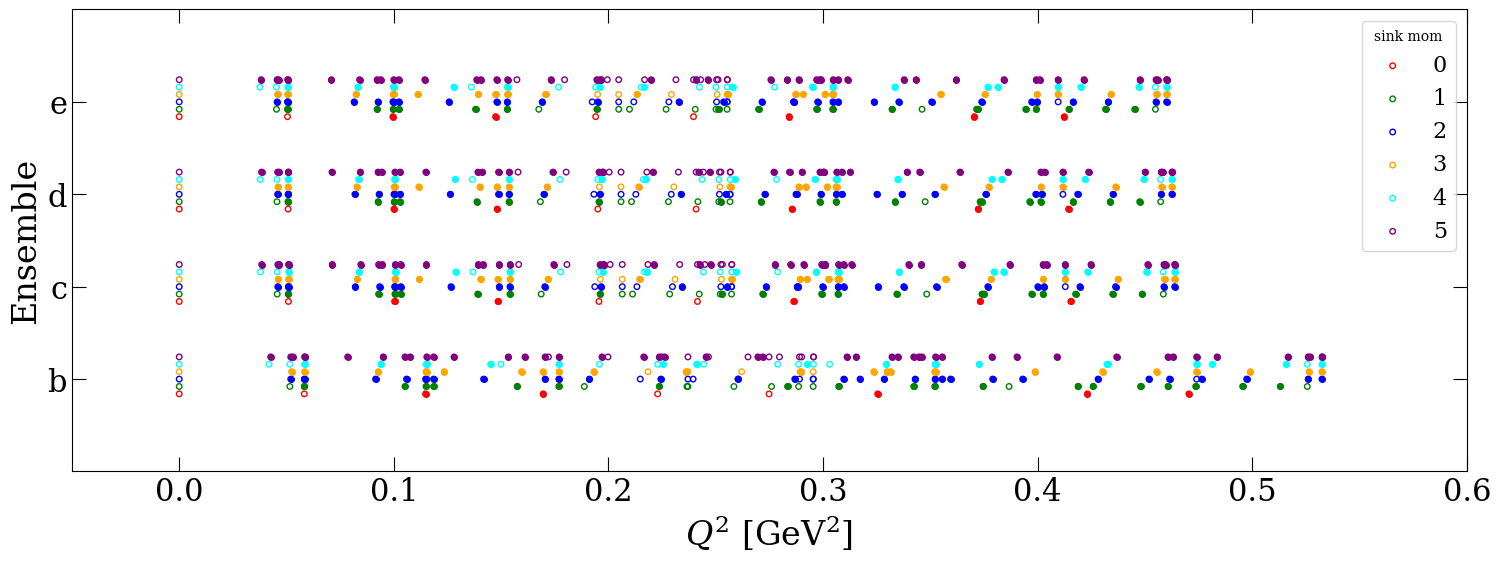

In [91]:
def mom2Q2(mom,ens):
    L=ens2N[ens]
    n1vec=np.array(mom[:3]); nqvec=np.array(mom[3:6])
    nvec=n1vec+nqvec
    pvec=nvec*(2*np.pi/L); p1vec=n1vec*(2*np.pi/L)
    qvec=nqvec*(2*np.pi/L)
    
    mN=938/ens2aInv[ens]
    
    xE_jk=np.sqrt(pvec.dot(pvec)+mN**2)
    xE1_jk=np.sqrt(p1vec.dot(p1vec)+mN**2)
    Q2_jk=(qvec.dot(qvec) - (xE_jk-xE1_jk)**2 )
    Q2=np.mean(Q2_jk)
    
    return Q2*ens2aInv[ens]**2/(1000**2)

def useMom(mom):
    px,py,pz=mom[3:]
    if pz>=py>=pz>=0:
        return True
    return False
    

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=18)
ax=axs[0,0]
ax.set_xlabel(r'$Q^2$ [GeV$^2$]')
# ax.set_xlim([-0.1,1.1])
ax.set_xlim([-0.05,0.6])
ax.set_ylabel(r'Ensemble')
ax.set_ylim([-1,4])
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(enss)

funcs_ri=[np.real,np.imag]

for iens,ens in enumerate(enss):
    max_mom2_pc={'cB211.072.64':9,'cC211.060.80':9,'cD211.054.96':9,'cE211.044.112':9}[ens2full[ens]]
    range_xyz=range(-int(np.sqrt(max_mom2_pc))-1,int(np.sqrt(max_mom2_pc))+2)
    moms_pc=[[x,y,z] for x in range_xyz for y in range_xyz for z in range_xyz if x**2+y**2+z**2<=max_mom2_pc]

    max_mom2_pf={'cB211.072.64':5,'cC211.060.80':5,'cD211.054.96':5,'cE211.044.112':5}[ens2full[ens]]
    range_xyz=range(-int(np.sqrt(max_mom2_pf))-1,int(np.sqrt(max_mom2_pf))+2)
    moms_pf=[[x,y,z] for x in range_xyz for y in range_xyz for z in range_xyz if x**2+y**2+z**2<=max_mom2_pf]
    
    colors=['r','g','b','orange','cyan','purple']
    for ipf2max in range(max_mom2_pf+1):
        moms=[pf+pc for pf in moms_pf for pc in moms_pc if pf[0]**2+pf[1]**2+pf[2]**2==ipf2max]
        
        Q2s_all=[round(mom2Q2(mom,ens),5) for mom in moms]
        Q2s=list(set(Q2s_all))
        Q2s.sort()
        
        Q2s_rank3=[]
        for iQ2,Q2 in enumerate(Q2s):
            print(f'{ens},{ipf2max},{iQ2}/{len(Q2s)}',end='          \r')
            inds=[i for i,ele in enumerate(Q2s_all) if ele==Q2]
            t_moms=[moms[ind] for ind in inds if useMom(moms[ind])]
            
            mpirs=[(mom,proj,insert,ri) for mom in t_moms for proj in projs for insert in inserts for ri in [0,1] if insert[0]!=insert[1] and useQ_noAvg(mom,proj,insert)[ri]]
            G=np.array([funcs_ri[ri](ME2FF(938/ens2aInv[ens],np.array(np.array(mom[:3])+mom[3:])*(2*np.pi/ens2N[ens]),(np.array(mom[:3]))*(2*np.pi/ens2N[ens]),proj,insert)) for mom,proj,insert,ri in mpirs])
            if len(G)!=0:
                U, S, VT = np.linalg.svd(G)
                tol = 1e-10
                rank = np.sum(S > tol)
                if rank==3:
                    Q2s_rank3.append(Q2)
        
        ys=[iens+(ipf2max-max_mom2_pf//2)*0.08]*len(Q2s)
        ax.scatter(Q2s,ys,color=colors[ipf2max] if ipf2max<len(colors) else None, label=ipf2max if iens==0 else None, facecolors='none')
        
        ys=[iens+(ipf2max-max_mom2_pf//2)*0.08]*len(Q2s_rank3)
        ax.scatter(Q2s_rank3,ys,color=colors[ipf2max] if ipf2max<len(colors) else None)
        
        # break

ax.legend(fontsize=16,title='sink mom');

# match configurations

In [ ]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/B_confs'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cB211.072.64/data_aux/cfgs_N=200,85,64_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_B'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

In [ ]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/configs_cC80_Christian.txt'
with open(path,'r') as f:
    cfgs=f.read().split("'")
    cfgs=[cfg for cfg in cfgs if len(cfg)==7 and '_r' in cfg]
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cC211.060.80/data_aux/cfgs_N=650_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_C'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

In [ ]:
cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_conn/configs_cD96_Christian.txt'
with open(path,'r') as f:
    cfgs=f.read().split("'")
    cfgs=[cfg for cfg in cfgs if len(cfg)==7 and '_r' in cfg]
    cfgs_conn=[cfg2new(cfg) for cfg in cfgs]
    
path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/dataPrepare/cD211.054.96/data_aux/cfgs_N=256,112_jlscg'
with open(path,'r') as f:
    cfgs_disc=f.read().splitlines()

cfgs=list(set(cfgs_conn).intersection(cfgs_disc))
cfgs.sort()

print(len(cfgs_conn),len(cfgs_disc),len(cfgs))

path='/p/project1/ngff/li47/code/glwc2/project2/02_discNJN_1D/data_aux/cfgs_run_D'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))